In [1]:
import sys

!{sys.executable} -m pip install numpy pandas scikit-learn seaborn matplotlib statsmodels openpyxl


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip


In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [3]:
orders = pd.read_csv('/Users/myelamar/Desktop/py_notes/testdata/olist_orders_dataset.csv')
order_items = pd.read_csv('/Users/myelamar/Desktop/py_notes/testdata/olist_order_items_dataset.csv')
customers = pd.read_csv('/Users/myelamar/Desktop/py_notes/testdata/olist_customers_dataset.csv')
payments = pd.read_csv('/Users/myelamar/Desktop/py_notes/testdata/olist_order_payments_dataset.csv')
products = pd.read_csv('/Users/myelamar/Desktop/py_notes/testdata/olist_products_dataset.csv')
reviews = pd.read_csv("/Users/myelamar/Desktop/py_notes/testdata/olist_order_reviews_dataset.csv")
sellers = pd.read_csv('/Users/myelamar/Desktop/py_notes/testdata/olist_sellers_dataset.csv')

In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [5]:
print(orders.isnull().sum() / len(orders) *100)
# Orders table contains 3% of the orders with null value so dropping null values in order table
print("size of order table before deleting the null values " + str(orders.shape))
orders.dropna(inplace=True)
print("size of order table after dropping the null values " + str(orders.shape))

# Checking whether any duplicate orders present in the table
print("duplicate orders found in the table " + str(orders.duplicated("order_id").sum()))
# No duplicate orders present in the table

# converting date fields dataType to datatime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

# Feature Engineering on Orders table
orders['delivered_on_time'] = np.where((orders['order_delivered_customer_date'] <= orders['order_estimated_delivery_date']), 1, 0)
orders['delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

print("orders not delivered on time " + str(len(orders.loc[orders['delivered_on_time'] == 0])))

orders.head()

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.160899
order_delivered_carrier_date     1.793023
order_delivered_customer_date    2.981668
order_estimated_delivery_date    0.000000
dtype: float64
size of order table before deleting the null values (99441, 8)
size of order table after dropping the null values (96461, 8)
duplicate orders found in the table 0
orders not delivered on time 7826


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivered_on_time,delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,9
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,2


In [6]:
print(order_items.info())
order_items.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
None


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [7]:
print(order_items.isnull().sum() / len(order_items) *100)
print("size of order_items table " + str(order_items.shape))
#finding duplicate orders
print("% of duplicate orders found in the order_items table " + str(order_items.duplicated("order_id").sum()/len(order_items) * 100))

# dropping duplicate orders 
order_items = order_items.drop_duplicates(subset='order_id')
print("size of order_items table after removing duplicates " + str(order_items.shape))

order_id               0.0
order_item_id          0.0
product_id             0.0
seller_id              0.0
shipping_limit_date    0.0
price                  0.0
freight_value          0.0
dtype: float64
size of order_items table (112650, 7)
% of duplicate orders found in the order_items table 12.413670661340435
size of order_items table after removing duplicates (98666, 7)


EDA on payments table

In [8]:
print(payments.info())
payments.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
None


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [9]:
print(payments.isnull().sum() / len(payments) *100)
print("size of order_items table " + str(payments.shape))
#finding duplicate orders
print("% of duplicate orders found in the payments table " + str(payments.duplicated("order_id").sum()))
# dropping duplicate orders 
payments = payments.drop_duplicates(subset='order_id')
print("size of order_items table after removing duplicates " + str(payments.shape))

order_id                0.0
payment_sequential      0.0
payment_type            0.0
payment_installments    0.0
payment_value           0.0
dtype: float64
size of order_items table (103886, 5)
% of duplicate orders found in the payments table 4446
size of order_items table after removing duplicates (99440, 5)


EDA on reviews table

In [10]:
print(reviews.info())
reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
None


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


review_id                  0.0
order_id                   0.0
review_score               0.0
review_comment_title       0.0
review_comment_message     0.0
review_creation_date       0.0
review_answer_timestamp    0.0
dtype: float64
size of reviews table (99224, 7)
% of duplicate orders found in the reviews table 551
size of reviews table after removing duplicates (98673, 7)


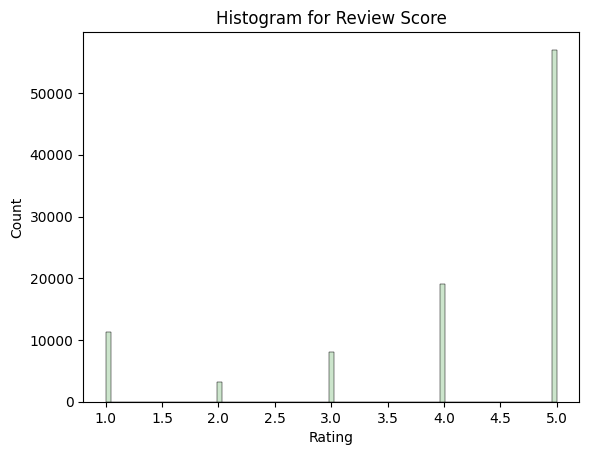

In [12]:
print(reviews.isnull().sum() / len(reviews) *100)
print("size of reviews table " + str(reviews.shape))

# 60% of review comments are missing from the table instead of deleting those marking it to empty value
reviews = reviews.fillna("")

print("% of duplicate orders found in the reviews table " + str(reviews.duplicated("order_id").sum()))
# dropping duplicate orders 
reviews = reviews.drop_duplicates(subset='order_id')
print("size of reviews table after removing duplicates " + str(reviews.shape))

#Feature engineering on reviews table
reviews['is_reviewed'] = np.where(((reviews['review_score'] ==5) & (reviews['review_comment_message'] != "")), 1, 0)
reviews['customer_satisfaction'] = np.where(reviews['review_score'] > 4, 1, 0)

# distribution of review scores
sns.histplot(reviews['review_score'], kde=False, color='green', alpha=0.2)
plt.title('Histogram for Review Score')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

EDA on Seller table

In [13]:
print(sellers.info())
sellers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
None


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [14]:
data = reviews.merge(orders, on="order_id", how="left") \
              .merge(order_items, on="order_id", how="left") \
              .merge(payments, on="order_id", how="left")

data['shipped_on_time'] = np.where((data['order_delivered_carrier_date'] <= data['shipping_limit_date']) & (data['order_delivered_carrier_date'].notna()), 1, 0)

In [15]:
final_data = data[['shipped_on_time', 'delivered_on_time', 'delivery_time',
                'payment_value', 'price', 'freight_value', 'is_reviewed', 'customer_satisfaction']]

In [16]:
final_data.head()

,shipped_on_time,delivered_on_time,delivery_time,payment_value,price,freight_value,is_reviewed,customer_satisfaction
0,1,1.0,6.0,397.26,185.00,13.63,0,0
1,1,1.0,9.0,88.09,79.79,8.30,0,1
2,1,1.0,13.0,194.12,149.00,45.12,0,1
3,1,1.0,10.0,222.84,179.99,42.85,1,1
4,0,1.0,18.0,1333.25,1199.00,134.25,1,1


In [17]:
final_data.corr()

,shipped_on_time,delivered_on_time,delivery_time,payment_value,price,freight_value,is_reviewed,customer_satisfaction
shipped_on_time,1.000000,0.187088,-0.231396,-0.045697,-0.036563,-0.036339,0.063733,0.148560
delivered_on_time,0.187088,1.000000,-0.587449,-0.016006,-0.019601,-0.040546,0.092553,0.222029
delivery_time,-0.231396,-0.587449,1.000000,0.068782,0.060001,0.214019,-0.092439,-0.233891
payment_value,-0.045697,-0.016006,0.068782,1.000000,0.907702,0.454413,0.006370,-0.022413
price,-0.036563,-0.019601,0.060001,0.907702,1.000000,0.420631,0.018141,0.001358
freight_value,-0.036339,-0.040546,0.214019,0.454413,0.420631,1.000000,0.005375,-0.028996
is_reviewed,0.063733,0.092553,-0.092439,0.006370,0.018141,0.005375,1.000000,0.437286
customer_satisfaction,0.148560,0.222029,-0.233891,-0.022413,0.001358,-0.028996,0.437286,1.000000


In [18]:
Q1 = final_data['delivery_time'].quantile(0.25)
Q3 = final_data['delivery_time'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define the range for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
filtered_df = final_data[(final_data['delivery_time'] >= lower_bound) & (final_data['delivery_time'] <= upper_bound)]


In [19]:
filtered_df.shape

(90915, 8)

/var/folders/rx/sq6thrd541b5sccsm7dv8rd40000gn/T/ipykernel_51547/1887507082.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="customer_satisfaction", y="delivery_time", data=filtered_data, palette="pastel")


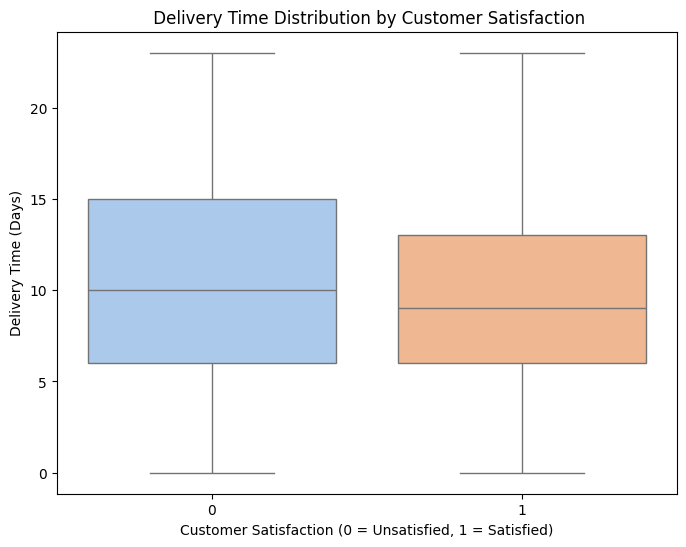

In [20]:
percentile_95 = filtered_df['delivery_time'].quantile(0.95)
filtered_data = filtered_df[filtered_df['delivery_time'] <= percentile_95]

plt.figure(figsize=(8, 6))
sns.boxplot(x="customer_satisfaction", y="delivery_time", data=filtered_data, palette="pastel")
plt.title(" Delivery Time Distribution by Customer Satisfaction")
plt.xlabel("Customer Satisfaction (0 = Unsatisfied, 1 = Satisfied)")
plt.ylabel("Delivery Time (Days)")
plt.show() 

In [23]:


X = filtered_df.drop(['customer_satisfaction'], axis=1)
y = filtered_df['customer_satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = HistGradientBoostingClassifier(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred))


Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.60      0.46      0.52      6898
           1       0.71      0.81      0.76     11285

    accuracy                           0.68     18183
   macro avg       0.66      0.64      0.64     18183
weighted avg       0.67      0.68      0.67     18183



In [26]:
model = HistGradientBoostingClassifier(random_state=42)

param_grid = {
    'max_iter': [100, 200, 300],
    'max_depth': [None, 3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_samples_leaf': [10, 20, 30]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score:.2f}")

y_pred = grid_search.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 100, 'min_samples_leaf': 20}
Best Cross-Validation Score: 0.67
Test Accuracy: 0.68
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.48      0.53      6898
           1       0.72      0.80      0.75     11285

    accuracy                           0.68     18183
   macro avg       0.65      0.64      0.64     18183
weighted avg       0.67      0.68      0.67     18183

